## Introduction
In this kernel, I'll demonstrate how to use Sohier's [BigQuery helper module](https://github.com/SohierDane/BigQuery_Helper/blob/master/bq_helper.py) to safely query the largest BigQuery dataset we've made available on Kaggle, [GitHub Repos](https://www.kaggle.com/github/github-repos). Weighing in at 3TB total, you can see how it would be easy for me to quickly exhaust my 5TB/30-day quota scanning lots of large tables. 

The `bq_helper` module simplifies the common read-only tasks we can do using the BigQuery Python client library on Kaggle and makes it a cinch to manage resource usage. This helper class works only in Kernels because we handle authentication on our side. This means you don't need to worry about anything like managing credentials or entering in credit card information to have fun learning how to work with BigQuery datasets.

You'll learn how to do the following:

1. Create a `BigQueryHelper` object
2. Understand the tables in the dataset
3. Estimate the size of your queries before you make them
4. Query safely, convert to `pandas.dataframe`, and visualize results

By the end of this kernel, you'll not only learn a lot about querying BigQuery datasets safely, but we'll also find out the most popular licenses used by open source projects on GitHub. Let's go!

In [1]:
import pandas as pd
# https://github.com/SohierDane/BigQuery_Helper
from bq_helper import BigQueryHelper

### Creating a BigQueryHelper object
To start, we use `bq_helper` to create a `BigQueryHelper` object. This requires the project name and dataset name as its two arguments. You can find out the project name and dataset name by clicking on the "Data" tab of this kernel. Select any table and you'll see the first two parts of the address (in the blue BigQuery Table box) separated by `.` correspond to the project and dataset names respectively:

* `bigquery-public-data`
* `github_repos`

Let's create a `BigQueryHelper` object for the GitHub dataset:

In [3]:
bq_assistant = BigQueryHelper("bigquery-public-data", "github_repos")

If you're following along in your own kernel, click on the "Environment Variables" tab in the console at the bottom of the editor pane. You'll now see a `BigQueryHelper` object in your environment.

### Get to know your data with simple read-only functions

Now that we have our `BigQueryHelper` object for the GitHub dataset, there are a few super simple read-only functions we can use to learn more about the data including:

* Listing tables
* Getting table schema
* Inspecting table rows

Next, the simplest read-only task we can do is list all of the tables in the dataset. You can of course preview the tables by looking at the "Data" tab, too.

In [4]:
%%time
bq_assistant.list_tables()

CPU times: user 22.9 ms, sys: 2.1 ms, total: 25 ms
Wall time: 609 ms


['commits',
 'contents',
 'files',
 'languages',
 'licenses',
 'sample_commits',
 'sample_contents',
 'sample_files',
 'sample_repos']

Good. We confirm that we see the same 9 tables that are shown in our "Data" tab. 

The GitHub BigQuery dataset doesn't have column-level descriptions for any of its tables (otherwise you could also look at them in the "Data" tab file previews), but if it did, looking at table schema using `bq_helper` would show them:

In [5]:
%%time
bq_assistant.table_schema("licenses")

CPU times: user 3.52 ms, sys: 1.07 ms, total: 4.59 ms
Wall time: 240 ms


[SchemaField('repo_name', 'string', 'NULLABLE', None, ()),
 SchemaField('license', 'string', 'NULLABLE', None, ())]

Finally, while you can preview the first 100 rows in the table previews in the "Data" tab, there's also an efficient way to look at the first few rows using `bq_helper`.

Because `SELECT *` will scan all rows of the columns you specify (and potentially burn lots of quota), it's best practice to avoid using it especially just to explore your data. Here's how you can look at the first few rows using `head` which uses the efficient `list_rows` function [as Sohier notes](https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package). Let's try it out on the `licenses` table:

In [6]:
%%time
bq_assistant.head("licenses", num_rows=10)

CPU times: user 4.19 ms, sys: 1.9 ms, total: 6.08 ms
Wall time: 451 ms


,repo_name,license
0,satrac/batchwriter,artistic-2.0
1,Eriklaes/tech.ed.gov,artistic-2.0
2,gitpan/Caffeinated_Markup_Language,artistic-2.0
3,dzhiqin/coolweathertest,artistic-2.0
4,pts01/glocales,artistic-2.0
5,huitoukest/asorm,artistic-2.0
6,ceroca/Nueva,artistic-2.0
7,gitpan/Geo-Raster,artistic-2.0
8,sgproduce/FarmPlans,artistic-2.0
9,gitpan/Fey-DBIManager,artistic-2.0


So far, these are the helper functions available in `bq_helper` that will let you get to safely know your data a bit before writing queries. Feel free to let us know if you'd like to see more functionality by opening an issue or submitting a PR to the [GitHub repo](https://github.com/SohierDane/BigQuery_Helper).

### Estimating query size

Now for the really cool part. We're eager to start analyzing the GitHub BigQuery dataset to uncover insights into open source software development, but we should be careful about how much data we scan in our queries. Let's make those free 5TB count!

Fortunately, the `bq_helper` module gives us tools to very easily estimate the size of our queries before we get ahead of ourselves. We simply write a `QUERY` using BigQuery's Standard SQL syntax then call the `estimate_query_size` function which will return the size of the query in GB. Let's give it a try.

[In this kernel](https://www.kaggle.com/mrisdal/github-commit-messages), I wrote a query which `SELECTS` 2000 rather short commit messages from the `commits` table. Let's use `estimate_query_size` to see how much data it scans.

In [7]:
QUERY = """
        SELECT message
        FROM `bigquery-public-data.github_repos.commits`
        WHERE LENGTH(message) > 6 AND LENGTH(message) <= 20
        LIMIT 2000
        """

In [8]:
%%time
bq_assistant.estimate_query_size(QUERY)

CPU times: user 2.42 ms, sys: 3.06 ms, total: 5.47 ms
Wall time: 407 ms


21.418168189004064

The above query would cost me nearly 18GB to run now. Now you can see why it's extremely helpful to know this without needing to actually expend the quota! Note that the query obviously doesn't return an object that's 17.6GB--it's only returning 2000 very short commit messages.

Let's experiment with estimating the size of a query that returns twice as many results:

In [9]:
QUERY = """
        SELECT message
        FROM `bigquery-public-data.github_repos.commits`
        WHERE LENGTH(message) > 6 AND LENGTH(message) <= 20
        LIMIT 4000 -- twice as many commit messages
        """

In [10]:
%%time
bq_assistant.estimate_query_size(QUERY)

CPU times: user 3.7 ms, sys: 1.1 ms, total: 4.8 ms
Wall time: 477 ms


21.418168189004064

Ah hah. See how it returns the same exact size estimate? This illustrates how using `LIMIT` to reduce the amount of data the query returns doesn't actually change how much data the query is scanning. The latter is what really counts against your quota.

Let's do one more experiment. What about the `WHERE` clause that I included? Let's remove that AND `LIMIT` and see if it increases the amount of data my query scans:

In [11]:
%%time
QUERY = """
        SELECT message
        FROM `bigquery-public-data.github_repos.commits`
        """

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.87 µs


In [12]:
%%time
bq_assistant.estimate_query_size(QUERY)

CPU times: user 4.06 ms, sys: 1.01 ms, total: 5.07 ms
Wall time: 374 ms


21.418168189004064

Again, we're scanning the same 17.6GB which we now clearly know is the full size of the `message` field. The lesson here that I hope you'll take away is that the data you're scanning is NOT equivalent to the data you expect the query to return as its result. I encourage you to [check out BigQuery's best practices docs](https://cloud.google.com/bigquery/docs/best-practices) for more information.

Don't be discouraged by this. There is some good news! When you _do_ make a query request, your results will be cached for some time by default. So as long as you're in the same interactive notebook session, you can run the same cell/query multiple times without expending multiples of the quota cost. Whew! This is especially helpful because when you click "New Snapshot" to save your work, your kernel will be freshly executed from top to bottom.

### Executing queries safely

Now that we're comfortable with the huge amounts of data at our fingertips and know we can confidently estimate the size of our queries, let's actually fetch some data!

The `query_to_pandas_safe` function is another `bq_helper` function that makes the call to execute our query. It has two advantages over using the base BigQuery Python client library:

* By default it won't execute a query with a size estimate over 1GB
* It returns a convenient pandas dataframe

Let's try out `query_to_pandas_safe` on our first query. If it works correctly, the query will fail to execute as we know it scans 17.6GB of data.

In [13]:
QUERY = """
        SELECT message
        FROM `bigquery-public-data.github_repos.commits`
        WHERE LENGTH(message) > 6 AND LENGTH(message) <= 20
        LIMIT 2000
        """

In [14]:
%%time
df = bq_assistant.query_to_pandas_safe(QUERY)

Query cancelled; estimated size of 21.418168189004064 exceeds limit of 1 GB
CPU times: user 4.41 ms, sys: 1.06 ms, total: 5.47 ms
Wall time: 460 ms


Thanks to `query_to_pandas_safe` we didn't actually execute a query that was larger than 1GB. Relief! If we were comfortable making a larger query, we would simply add an argument `max_gb_scanned`. To successfully execute this query, I would add `max_gb_scanned=18`.

### Putting it all together in four steps

We've come a long way in learning how to safely handle large datasets in BigQuery. Let's see if we can put it all together to make a reasonably sized query, get a pandas dataframe back, and visualize the results. Boom.

Returning to my question at the beginning of this kernel, I want to know the licenses most frequently used by projects on GitHub. After writing my query, I will:

1. Estimate the size of my query to make sure it's not too huge
2. Execute my query using `query_to_pandas_safe` to get my results in a pandas dataframe
3. Explore the results
3. Visualize the results

In [16]:
QUERY = """
        SELECT license, COUNT(*) AS count
        FROM `bigquery-public-data.github_repos.licenses`
        GROUP BY license
        ORDER BY COUNT(*) DESC
        """

#### Step 1. Estimate the size of the query I've written above.

In [17]:
%%time
bq_assistant.estimate_query_size(QUERY)

CPU times: user 3.36 ms, sys: 1.93 ms, total: 5.29 ms
Wall time: 412 ms


0.02163583878427744

Executing this query will only cost me 0.02 GB which I'm comfortable with given my 5TB 30-day quota. 

#### Step 2. Use `query_to_pandas_safe` to get the results back as a pandas dataframe:

In [18]:
%%time
df = bq_assistant.query_to_pandas_safe(QUERY)

CPU times: user 17.6 ms, sys: 3.38 ms, total: 21 ms
Wall time: 1.47 s


Ahh, perfect silence. Because my query scanned less than 1GB of data, it executed without canceling. 

#### Step 3. Explore the results of the query

Now that our results are in a pandas dataframe, the data is super easy to manipulate. Let's check out the size of our dataframe and compare to the amount of data we know we scanned (0.02GB):

In [19]:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))

Size of dataframe: 1175 Bytes


Much, much smaller! Again, this is to reiterate that the data you scan is much different from the results you get back from your query. This is again because BigQuery is scanning the entire contents of the `license` field in the `licenses` table. 

Now we can take a look at the first few rows returned:

In [21]:
df

,license,count
0,mit,1526661
1,apache-2.0,443397
2,gpl-2.0,308318
3,gpl-3.0,306268
4,bsd-3-clause,136198
5,bsd-2-clause,49763
6,unlicense,41686
7,agpl-3.0,36994
8,lgpl-3.0,35758
9,cc0-1.0,24108


It's clear that the MIT license is the most popular among open source projects in the GitHub BigQuery dataset. How many licenses did we return, anyway?

In [22]:
df.shape

(15, 2)

We've got the counts for each of fifteen licenses used in the dataset.

#### Step 4. Visualize the results

The results of our query (and our efforts learning BigQuery) will all become real once we visualize them! I'm going to use `matplotlib` with `seaborn` to create a bar plot showing the count of GitHub projects by type of license.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

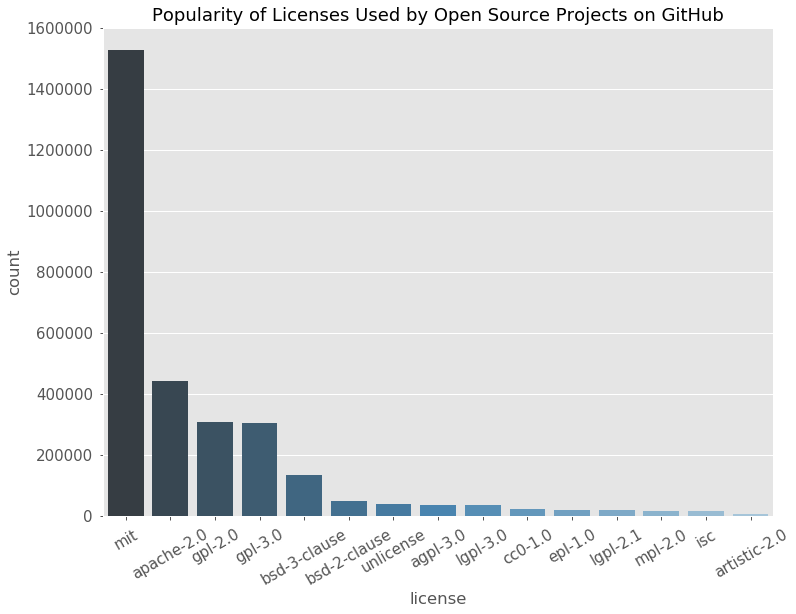

In [24]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

f, g = plt.subplots(figsize=(12, 9))
g = sns.barplot(x="license", y="count", data=df, palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.title("Popularity of Licenses Used by Open Source Projects on GitHub")
plt.show(g)

Beautiful! We already knew that MIT was the most popular license by far, but here we see it in plain contrast to the next most common licenses, Apache 2.0 and GPL 2.0 and 3.0. For the record, this kernel is Apache 2.0-licensed. :)

## Conclusion

I hope you've enjoyed this kernel and learned at least something new. I know I felt confident about exploring this massive 3TB dataset knowing the functions available to me in `bq_helper` would prevent me from accidentally exceeding my quota. Here are some additional resources for working with BigQuery datasets in Kaggle Kernels:

* New to SQL? Learn this practical language by signing up for our [5-day SQL Scavenger Hunt](https://www.kaggle.com/sql-scavenger-hunt) which starts February 15th
* [A collection of all BigQuery resources on Kaggle](https://www.kaggle.com/product-feedback/48573)
* [Learn more about the BigQuery Python client library here](https://www.kaggle.com/sohier/beyond-queries-exploring-the-bigquery-api)
* Explore [all BigQuery datasets available on Kaggle](https://www.kaggle.com/datasets?filetype=bigQuery)--each has its own "starter kernel" for you to fork